## Utilisation de pyspark pour un pipeline machine learning : classification du genre sur les discours politiques français

### Jing TAN & Melchior PRUGNIAUD 
###### MS DS || ENSAE

Ce sujet réalise des traitements de NLP. Etant donné la complexité de certaines fonctions que nous allons utilisés, il est important de distribué ces computations afin de réduire le temps de travail qui normalement sur une seule machine prendrait des heures. C'est pourquoi utiliser PySpark nous semble être une bonne solution.

Le but ici est de comprendre l'utilisation de PySpark tout en développant un pipeline de machine learning facilement exécutable.

Nous avions un problème pour utiliser plusieurs packages sur le cluster de l'ENSAE, c'est pourquoi nous avons au final décider de réaliser l'ensemble des opérations directement sous collab car nous avons plus de maniabilité que sur le cluster.


### Partie I : Methode de Machine Learning avec des hyperparamètres réglés

#### Colab Setup

In [0]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.0

# Quick SparkSession start
import sparknlp
spark = sparknlp.start()

print("Spark NLP version")
sparknlp.version()
print("Apache Spark version")
spark.version

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 61kB/s 
     |████████████████████████████████| 204kB 44.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130388 sha256=7b16ffff769dc0a6822b94d68083d36da1cfde593201a02a1ce730064096b24f
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 122kB 2.7MB/s 
Spark NLP version
Apache Spark version


'2.4.4'

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, size
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from functools import reduce
from sparknlp.annotator import Tokenizer,SentenceDetector,StopWordsCleaner,PerceptronApproach
from operator import add
import nltk
import sparknlp
from collections import Counter
from pyspark.sql.types import StringType,ArrayType
from sparknlp.base import Pipeline,DocumentAssembler
from sparknlp.pretrained import PretrainedPipeline
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### Construction d'une session spark pour réaliser les divers traitements

Dans un premier temps nous allons créer une [session spark](https://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#pyspark.sql.SparkSession) afin de pouvoir intéragir avec un dataset.


In [0]:
spark = sparknlp.start()
spark

Importons le dataframe, un import direct dans spark cause des problèmes vis à vis des NaN et les colonnes ne sont plus bien alignés. C'est pourquoi nous passons d'abord par pandas pour ensuite transferer notre dataframe dans spark.

Le dataframe que nous prenons est issus d'un scraping du site https://www.vie-publique.fr/discours ,réalisé à l'aide de scrapy (scrapper disponible dans le dossier scraper). Nous allons dans un premier temps réalisé des opérations visant à obtenir le sexe lié à chaque discours via une base de prénoms de l'INSEE.


### /!\ Ne pas executer ci dessous  /!\
Au départ nous voulions éxecuter ces manipulations sous pyspark mais sans savoir pourquoi (peut être une taille trop conséquente?), au final il n'était plus possible montrer quelques lignes pour vérifier si le résultat escompté était le bon et il n'était pas possible non plus d'enregistrer le dataframe ensuite en csv (ou le rexporter vers pandas via toPandas()).

In [0]:
df = pd.read_csv('discours6.csv',sep=",")

De plus, nous ne gardons que les discours et les déclarations car nous sommes quasi sur pour chaque texte qu'il s'agisse bien d'un monologue. Pour les autres plusieurs personnes peuvent parler.

In [0]:
df = df[(df.Type.apply(lambda x:x.lower()) == 'discours') | (df.Type.apply(lambda x:x.lower()) =="déclaration")]
df = df[df.Texte.notna()]
df.fillna('',inplace=True)
df.Nom = df.Nom.map(str).apply(lambda x : x.replace(","," "))
df['PRENOM']=df.Prenom.map(str).apply(lambda x:x.upper())
df.drop('Prenom',axis=1,inplace=True)

In [0]:
df = spark.createDataFrame(df)

Chargeons désormais la base prenoms et manipulons là pour obtenir un dataframe permettant par la suite de joindre la base discours

In [0]:
prenoms = spark.read.csv("nat2018.csv",sep=";",header=True)
print('Nombre de ligne {} au départ'.format(prenoms.count()))
prenoms = prenoms.groupby(['preusuel','sexe']).sum()
print('Nombre de ligne {} après groupBy'.format(prenoms.count()))
prenoms = prenoms.dropDuplicates()
print('Nombre de ligne {} après dropDuplicates'.format(prenoms.count()))

In [0]:
df = df.join(prenoms,df.PRENOM == prenoms.preusuel,how='left')
df = df.drop(*['PRENOM','preusuel','Lien'])

In [0]:
sub = df.select(['Date','Sexe']).sample(withReplacement=False, fraction=0.1, seed=42)
sub_pd= sub.toPandas()

N'en fini pas de tourner... pour finir sur un timeout.
### Executer ici

Nous réalisons donc la jointure sur pandas, ce qui ne prends presque pas de temps. 

In [0]:
def remove_source(x):
    """
      Input : Texte 
      Output : Texte sans le dernier paragraphe
    """
    x =  x[:x.find('Source:')]
    return x[:x.find('Source http')]

In [0]:
df = pd.read_csv('discours6.csv',sep=",")
df = df[(df.Type.apply(lambda x:x.lower()) == 'discours') | (df.Type.apply(lambda x:x.lower()) =="déclaration")]
df = df[df.Texte.notna()]
df.fillna('',inplace=True)
df.Nom = df.Nom.map(str).apply(lambda x : x.replace(","," "))
df['PRENOM']=df.Prenom.map(str).apply(lambda x:x.upper())
df.drop('Prenom',axis=1,inplace=True)
prenoms = pd.read_csv('nat2018.csv',sep=';')
prenoms=prenoms.groupby(['preusuel','sexe'],as_index=False).sum()
prenoms=prenoms.sort_values(['nombre'],ascending=True)
prenoms=prenoms.drop_duplicates(subset=['preusuel'],keep='last')
prenoms=prenoms[['preusuel','sexe']]
df = pd.merge(df,prenoms,how='left',left_on='PRENOM',right_on='preusuel')
df.drop(['preusuel','Lien'],axis=1,inplace=True)
df =  df[df.Texte.apply(len)>1000] #on ne garde que les texte avec au moins 1000caractères
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [0]:
df.head(2)

,Id,Titre,Type,Theme,Nom,Fonction,Date,Tags,Texte,PRENOM,sexe
0,273623,"Déclaration de M. Franck Riester, ministre de ...",déclaration,Société,Riester,-Ministre de la culture,2020-02-26T12:00:00Z,"Culture - Médias,Média","Merci monsieur le président, cher Bruno Studer...",FRANCK,1.0
1,273677,"Déclaration de Mme Amélie de Montchalin, secré...",déclaration,International,de Montchalin,-Secrétaire d'État aux affaires européennes,2020-02-26T12:00:00Z,"Union européenne,Politique agricole commune","Merci Monsieur le Président, Monsieur le Séna...",AMÉLIE,2.0


In [0]:
df.Texte = df.Texte.astype(str)

In [0]:
print('En moyenne, la longueur des textes est de {} caractères.'.format(round(df.Texte.apply(len).mean())))
print('Le corpus contient {} discours et déclarations politiques.' .format(len(df)))
print('Il y a {} hommes et {} femmes qui les prononcent.'.format(df.sexe.map(str).value_counts()[0],df.sexe.map(str).value_counts()[1]))

En moyenne, la longueur des textes est de 11912 caractères.
Le corpus contient 36724 discours et déclarations politiques.
Il y a 26486 hommes et 8886 femmes qui les prononcent.


Nous sommes clairement dans le cadre d'un jeu de données non balancés. Par la suite nous prendrons un sous échantillon de ce dataframe complet pour réaliser nos modélisations. De ce fait, en appliquant une méthode de sous échantillonnage pour égaliser le nombre d'hommes et de femmes.

In [0]:
seed = 42
#Créeons d'ores et déjà le dataframe de train/test équilibré et créons aussi un dataframe de validation ayant les mêmes proportions pour observer si notre futur modèle fonctionne comme attendu.
df_eq = pd.concat([df[df.sexe == 1].sample(2500,random_state=seed),df[df.sexe == 2].sample(2500,random_state=seed)])
df_eq_id =df_eq.Id
df_valid = pd.concat([df[(~df.Id.isin(df_eq_id.values)) & (df.sexe == 1)].sample(int(len(df[df.sexe == 1])/len(df)*5000)),df[(~df.Id.isin(df_eq_id.values)) & (df.sexe == 2)].sample(5000-int(len(df[df.sexe == 1])/len(df)*5000))])

In [0]:
print(df_eq.shape,df_eq.sexe.value_counts())
print(df_valid.shape,df_valid.sexe.value_counts())

### Statistiques descriptives

Désormais, nous allons réaliser des statistiques descriptives et faire quelques visualisation sur nos données. Cette partie est réalisé sous pandas sur l'ensemble de toute la base.

Dans un premier temps, on remarque qu'il y a 3/4 des discours qui sont énoncés par des hommes et seuelement 25% par des femmes, ce qui justifie notre sous échantillonnage plus tard.

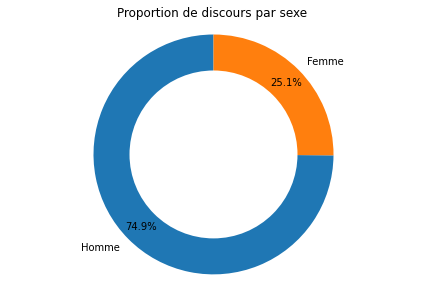

In [0]:
labels = ['Homme','Femme']
#colors = ['#ffcc99','#ff9999']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Proportion de discours par sexe")
plt.show()

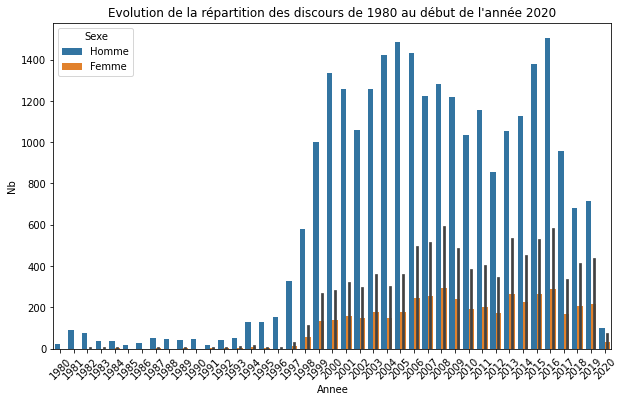

In [0]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Homme'
        else:
            sexe='Femme'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
data=data[data['Annee']>='1980']
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution de la répartition des discours de 1980 au début de l'année 2020")
plt.show()

On remarque que le nombre de prises de paroles féminines a augmenté au cours du temps mais qu'il reste dérisoire par apport au nombre de prise de paroles d'homme.

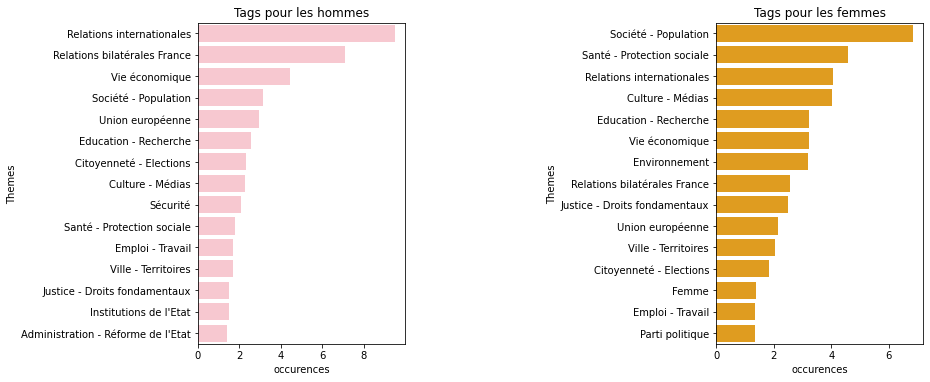

In [0]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Femme'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Homme'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Homme')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color='pink')
plt.title("Tags pour les hommes")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Femme')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color = 'orange')
plt.title("Tags pour les femmes")
plt.subplots_adjust(wspace = 1.5)

Visiblement, hommes et femmes ne parlent pas des sujets identiques. Par exemple, les femmes parlent plus de la société tandis que les hommes plus des relations internationales. Cela est sans doute lié aux différents ministères.

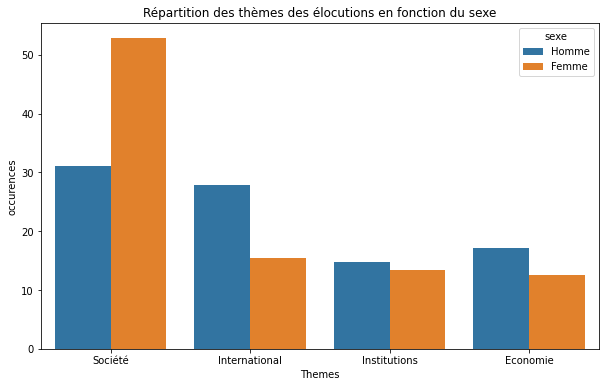

In [0]:
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Homme'
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Femme'
d = pd.concat([d_m,d_f])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

### Passons maintenant au feature engeenering sur les textes de notre corpus

Pour se faire, nous allons dans un premier temps prendre notre dataframe equlibré.

In [0]:
df_eq = pd.read_csv('df_eq.csv')
df_eq = df_eq[df_eq.columns[1:]]
df_eq.fillna('',inplace=True)

In [0]:
sparkDfEq = spark.createDataFrame(df_eq)

In [0]:
sparkDfEq.show(5)

+------+--------------------+-----------+--------------------+-------------------+--------+--------------------+--------------------+--------------------+--------+----+
|    Id|               Titre|       Type|               Theme|                Nom|Fonction|                Date|                Tags|               Texte|  PRENOM|sexe|
+------+--------------------+-----------+--------------------+-------------------+--------+--------------------+--------------------+--------------------+--------+----+
|149052|Déclaration de M....|déclaration|             Société|Donnedieu de Vabres|        |2005-08-30T12:00:00Z|Culture - Médias,Art|Madame la Ministr...|  RENAUD| 1.0|
|135806|Déclaration de M....|déclaration|Economie,Institut...|            Lambert|        |2002-10-01T12:00:00Z|Finances publique...|Monsieur le prési...|   ALAIN| 1.0|
|199346|Déclaration de M....|déclaration|            Economie|             Macron|        |2016-05-04T12:00:00Z|Energie - Transpo...|Monsieur le Déput...|E

Créons tout d'abord un pipeline permetttant de faire du pré-processing sur le texte. 
Nous allons utiliser le module sparknlp pour gérer l'ensemble du preprocessing (il est impossible visiblement de configurer manuellement sur le cluster de l'ensae nltk et spacy, de plus sparknlp semble avoir de meilleur résultat que ces deux packages).

Tout d'abord nous créons un pipeline spark nlp pour obtenir diverses colonnes.

In [0]:
pct = [el for el in '...'+'\x92'+'«'+'»'+'``'+"''"+'``'+'('+ ')']
document_assembler = DocumentAssembler() \
    .setInputCol("Texte")
sentence_detector = SentenceDetector() \
    .setInputCols("document") \
    .setOutputCol("phrase")
tokenizer = Tokenizer() \
    .setInputCols(["phrase"]) \
    .setOutputCol("Token") \
    .setSplitChars(['-']) \
    .setContextChars(pct)
stop_words_cleaner = StopWordsCleaner() \
        .setInputCols(["Token"]) \
        .setOutputCol("CleanToken") \
        .setCaseSensitive(False) \
        .setStopWords(list(fr_stop))
pos_tagger = PerceptronModel.pretrained(name="pos_ud_gsd",lang="fr") \
    .setInputCols(["Token", "phrase"]) \
    .setOutputCol("pos")
Pron = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Pron") \
    .setRegexParsers(["<PRON>"])
Nom = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Nom") \
    .setRegexParsers(["<NOUN>"])
Det = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Det") \
    .setRegexParsers(["<DET>"])
Punct = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Punct") \
    .setRegexParsers(["<PUNCT>"])
Adj = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("ADJ") \
    .setRegexParsers(["<ADJ>"])
Adp = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Adp") \
    .setRegexParsers(["<ADP>"])
Verb = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Verb") \
    .setRegexParsers(["<VERB>"])
Cconj = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Cconj") \
    .setRegexParsers(["<CCONJ>"])
Num = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Num") \
    .setRegexParsers(["<NUM>"])
Propn = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Propn") \
    .setRegexParsers(["<PROPN>"])
Adv = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Adv") \
    .setRegexParsers(["<ADV>"])
Sconj = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Sconj") \
    .setRegexParsers(["<SCONJ>"])
Aux = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Aux") \
    .setRegexParsers(["<AUX>"])
Intj = Chunker() \
    .setInputCols(["document", "pos"]) \
    .setOutputCol("Intj") \
    .setRegexParsers(["<INTJ>"])

pos_ud_gsd download started this may take some time.
Approximate size to download 3.4 MB
[OK!]


In [0]:
nlpPipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector, 
    tokenizer,
    stop_words_cleaner,
    pos_tagger,
    Pron,
    Nom,
    Det,
    Punct,
    Verb,
    Adj,
    Adp,
    Cconj,
    Num,
    Propn,
    Adv,
    Sconj,
    Aux,
    Intj
])

In [0]:
nlpPipelineDF = nlpPipeline.fit(sparkDfEq).transform(sparkDfEq)

In [0]:
cols = ['NbToken','NbVerb','NbPron','NbNom','NbDet','NbPunct','NbAdj','NbAdp','NbCconj','NbNum','NbPropn','NbAdv','NbSconj','NbAux','NbIntj']
var = ["Token",'Verb','Pron','Nom',"Det","Punct","Adj","Adp","Cconj","Num","Propn","Adv","Sconj","Aux","Intj"]
for v,c in zip(var,cols):
  nlpPipelineDF = nlpPipelineDF.withColumn(c,size(nlpPipelineDF[v]))

In [0]:
nlpPipelineDF.show(5)

+------+--------------------+-----------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+-------+------+------+-----+-----+-------+-----+-----+-------+-----+-------+-----+-------+-----+------+
|    Id|               Titre|       Type|               Theme|                 Nom|Fonction|                Date|                Tags|               Texte|  PRENOM|sexe|            document|              phrase|               Token|          CleanToken|                 pos|                Pron|                 Det|               Punct|                Verb|       

Très honnetement, le but était d'ici de construire des modèles à la fois à l'aide de variables tirés du texte comme un nombre de pronom personnel, de mot unique ou un score appellé la f measure testé par d'autres personnes dans le contraire de classification de texte mais il semblerait que les fonctions que nous tentons d'appliquer à l'aide de udf ne tournent pas ou alors beaucoup plus longtemps que les mêmes fonctions sur un pandas. De plus, il nous est à chaque fois impossible d'arriver à obtenir un toPandas() ce qui nous empêche de faire la pacerelle entre les deux (et dans un environnement de données massives ce n'est pas recommandé). C'est pourquoi, nous allons uniquement nous concentrer sur des modèles crée à l'aide de pipeline de spark.ml avec des word embeddings.


## Construction d'une baseline

Nous allons, à l'aide des nos différents word embeddings, tenter de classifier correctement le genre.

Pour se faire nous allons split notre dataset en 80% de test et 20% de train.

Par la suite nous allons tuner nos différents résultats à l'aide d'une gridsearchCV.



In [0]:
import pandas as pd

df_eq = pd.read_csv('df_eq.csv')
df_eq = df_eq[df_eq.columns[1:]]
df_eq.fillna('',inplace=True)
def encode(x):
  if x == 1:
    return 0
  else:
    return 1
df_eq.sexe = df_eq.sexe.apply(encode)

In [0]:
spark = SparkSession \
    .builder \
    .appName("DiscoursFrancais") \
    .getOrCreate() 

In [0]:
df = spark.createDataFrame(df_eq)

In [0]:
df = df.select(*['sexe','Texte'])
df.show(2)

+----+--------------------+
|sexe|               Texte|
+----+--------------------+
|   0|Madame la Ministr...|
|   0|Monsieur le prési...|
+----+--------------------+
only showing top 2 rows



Creation d'un pipeline

In [0]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,Word2Vec,CountVectorizer, IDF,StringIndexer
tokenizer = Tokenizer(inputCol='Texte',outputCol="token")
stopword = StopWordsRemover(inputCol="token", outputCol="clean_token").setStopWords(list(fr_stop))
word2vec = Word2Vec(inputCol='clean_token',outputCol='embedding1',seed=42,vectorSize=100,minCount=8)
countVec = CountVectorizer(inputCol='clean_token',outputCol='rawFeatureCountVec')#minDF=0.1,minTF=0.05,vocabSize=10000
idf = IDF(inputCol="rawFeatureCountVec", outputCol="embedding2",minDocFreq=5)
label_stringIdx = StringIndexer(inputCol = "sexe", outputCol = "label")

In [0]:
pipeline1 = Pipeline(stages=[
                             tokenizer,
                             stopword,
                             word2vec,
                             countVec,
                             idf,
                             label_stringIdx
])

In [0]:
pipelineFit = pipeline1.fit(df)
dataset = pipelineFit.transform(df)
dataset.show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|sexe|               Texte|               token|         clean_token|          embedding1|  rawFeatureCountVec|          embedding2|label|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|   0|Madame la Ministr...|[madame, la, mini...|[madame, ministre...|[0.00533969741751...|(262144,[0,1,3,4,...|(262144,[0,1,3,4,...|  0.0|
|   0|Monsieur le prési...|[monsieur, le, pr...|[monsieur, présid...|[0.00399028548548...|(262144,[0,1,3,4,...|(262144,[0,1,3,4,...|  0.0|
|   0|Monsieur le Déput...|[monsieur, le, dé...|[monsieur, député...|[0.02515808166170...|(262144,[0,1,3,4,...|(262144,[0,1,3,4,...|  0.0|
|   0|UNE RESPONSABILIT...|[une, responsabil...|[responsabilité, ...|[0.05184071906319...|(262144,[0,1,2,3,...|(262144,[0,1,2,3,...|  0.0|
|   0|« Nous ne devons ...|

Désormais faisons notre split.

In [0]:
train,test = dataset.randomSplit([0.8, 0.2], seed = 42)

Ici se trouve deux fonctions permettant de comparer les résultats de nos différentes méthodes.

In [0]:
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    scorer)
import numpy as np

def print_resultats(y_true,y_pred,mode='train'):
  
  print(f'================{mode.upper()}=================')
  print(classification_report(y_true, y_pred))
  print ("Accuracy : ",accuracy_score(y_true,y_pred))
  cm = confusion_matrix(y_true,y_pred)
  ROC = roc_auc_score(y_true,y_pred) 
  print ("AUC : ",ROC)
  plt.figure(figsize=(12,10))
  sns.heatmap(cm/np.sum(cm), annot=True, 
          fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
  plt.show()

def model_report(y_true,y_pred) :

  accuracy     = accuracy_score(y_true,y_pred)
  recallscore  = recall_score(y_true,y_pred)
  precision    = precision_score(y_true,y_pred)
  roc_auc      = roc_auc_score(y_true,y_pred)
  f1score      = f1_score(y_true,y_pred)     
  df = pd.DataFrame({ "Accuracy_score"  : [accuracy],
                    "Recall_score"    : [recallscore],
                    "Precision"       : [precision],
                    "f1_score"        : [f1score],
                    "Area_under_curve": [roc_auc],
                    })
  return df

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Le premier embedding est un Word2Vec non tuné.

In [0]:
import sklearn 
import datetime
from pyspark.ml.classification import LogisticRegression,NaiveBayes,DecisionTreeClassifier, RandomForestClassifier,LinearSVC


In [0]:

train = train.select(*['embedding1','label'])
test = test.select(*['embedding1','label'])
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
lr = LogisticRegression(featuresCol = 'embedding1', labelCol = 'label', maxIter=100,predictionCol='lrEmbedding1')
dtc = DecisionTreeClassifier(featuresCol='embedding1',labelCol='label',predictionCol='dtcEmbedding1',seed=42)
rfc = RandomForestClassifier(featuresCol='embedding1',labelCol='label',predictionCol='rfcEmbedding1',seed=42)
preds = ['lrEmbedding1','dtcEmbedding1','rfcEmbedding1',]
models = [lr,dtc,rfc]

for model,pred in zip(models,preds):
  print(model)
  print(datetime.datetime.now())
  Model = model.fit(train)
  predictions_train = Model.transform(train)
  predictions_test = Model.transform(test)
  print(datetime.datetime.now())
  y_true = predictions_train.select(['label']).collect()
  y_true_test = predictions_test.select(['label']).collect()
  print(datetime.datetime.now())
  y_pred = predictions_train.select([pred]).collect()
  y_pred_test=predictions_test.select([pred]).collect()
  modeldf = pd.concat([modeldf,model_report(y_true,y_pred)])
  modeldf = pd.concat([modeldf,model_report(y_true_test,y_pred_test)])

modeldf['nom']=['RegLog_train','RegLog_test','DTC_train','DTC_test','RFC_train','RFC_test']
modeldf.set_index(['nom'])


LogisticRegression_34e80d516e63
2020-05-15 15:01:52.471557
2020-05-15 15:04:03.398510
2020-05-15 15:05:13.460793
DecisionTreeClassifier_c4bc9ce5bc73
2020-05-15 15:06:20.785399
2020-05-15 15:08:22.260315
2020-05-15 15:09:28.454295
RandomForestClassifier_cb1bd6d55789
2020-05-15 15:10:35.687956
2020-05-15 15:12:50.926113
2020-05-15 15:13:56.044322


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
RegLog_train,0.711920,0.7245,0.708211,0.716263,0.711872
RegLog_test,0.704433,0.7080,0.696850,0.702381,0.704485
DTC_train,0.697114,0.7995,0.664865,0.725993,0.696727
DTC_test,0.633498,0.7180,0.608475,0.658716,0.634728
RFC_train,0.721455,0.7690,0.703568,0.734830,0.721276
RFC_test,0.673892,0.7220,0.652803,0.685660,0.674592


Le model ayant les meilleures performanaces sur le test set est la regression logistique.

================TEST=================
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71       515
         1.0       0.70      0.71      0.70       500

    accuracy                           0.70      1015
   macro avg       0.70      0.70      0.70      1015
weighted avg       0.70      0.70      0.70      1015

Accuracy :  0.7044334975369458
AUC :  0.7044854368932039


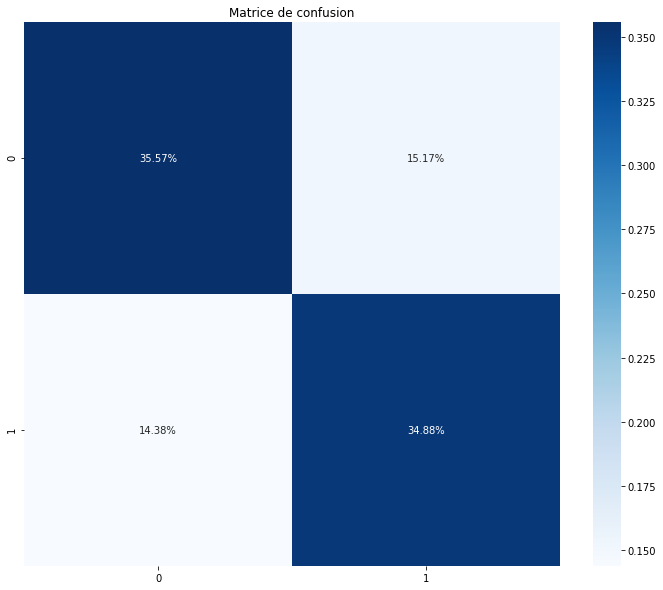

In [0]:
lr = LogisticRegression(featuresCol = 'embedding1', labelCol = 'label', maxIter=100,predictionCol='lrEmbedding1')
Model = lr.fit(train)
predictions_test = Model.transform(test)
y_true = predictions_test.select(['label']).collect()
y_pred = predictions_test.select(['lrEmbedding1']).collect()
print_resultats(y_true,y_pred,mode='test')

On remarque que le modele fait environ le même taux d'erreur pour chacune des classes. 

Passons cette fois-ci au TF-IDF.


In [0]:
train,test = dataset.randomSplit([0.8, 0.2], seed = 42)

In [0]:
train = train.select(*['embedding2','label'])
test = test.select(*['embedding2','label'])
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
lr = LogisticRegression(featuresCol = 'embedding2', labelCol = 'label', maxIter=100,predictionCol='lrEmbedding2')
dtc = DecisionTreeClassifier(featuresCol='embedding2',labelCol='label',predictionCol='dtcEmbedding2',seed=42)
rfc = RandomForestClassifier(featuresCol='embedding2',labelCol='label',predictionCol='rfcEmbedding2',seed=42)
preds = ['lrEmbedding2','dtcEmbedding2','rfcEmbedding2',]
models = [lr,dtc,rfc]
for model,pred in zip(models,preds):
  print(model)
  print(datetime.datetime.now())
  Model = model.fit(train)
  predictions_train = Model.transform(train)
  predictions_test = Model.transform(test)
  print(datetime.datetime.now())
  y_true = predictions_train.select(['label']).collect()
  y_true_test = predictions_test.select(['label']).collect()
  print(datetime.datetime.now())
  y_pred = predictions_train.select([pred]).collect()
  y_pred_test=predictions_test.select([pred]).collect()
  modeldf = pd.concat([modeldf,model_report(y_true,y_pred)])
  modeldf = pd.concat([modeldf,model_report(y_true_test,y_pred_test)])
modeldf['nom']=['RegLog_train','RegLog_test','DTC_train','DTC_test','RFC_train','RFC_test']
modeldf.set_index(['nom'])


LogisticRegression_f5a44d7e4e4e
2020-05-15 15:29:02.929838
2020-05-15 15:30:02.593459
2020-05-15 15:31:09.930043
DecisionTreeClassifier_19a9dab88fa8
2020-05-15 15:32:17.365195
2020-05-15 15:36:39.603640
2020-05-15 15:37:47.878695
RandomForestClassifier_820d6fb3789f
2020-05-15 15:38:57.627575
2020-05-15 15:43:28.788493
2020-05-15 15:44:41.769437


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
RegLog_train,1.000000,1.0000,1.000000,1.000000,1.000000
RegLog_test,0.749754,0.7320,0.753086,0.742394,0.749495
DTC_train,0.727729,0.6875,0.749319,0.717080,0.727881
DTC_test,0.729064,0.6740,0.750557,0.710221,0.728262
RFC_train,0.721957,0.7365,0.717137,0.726690,0.721902
RFC_test,0.698522,0.7020,0.690945,0.696429,0.698573


================TEST=================
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       515
         1.0       0.75      0.73      0.74       500

    accuracy                           0.75      1015
   macro avg       0.75      0.75      0.75      1015
weighted avg       0.75      0.75      0.75      1015

Accuracy :  0.7497536945812808
AUC :  0.7494951456310679


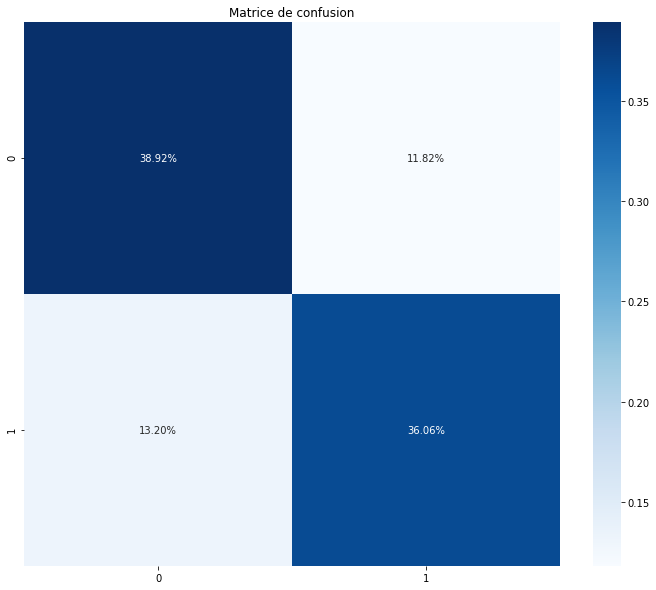

In [0]:
lr = LogisticRegression(featuresCol = 'embedding2', labelCol = 'label', maxIter=100,predictionCol='lrEmbedding2')
Model = lr.fit(train)
predictions_test = Model.transform(test)
y_true = predictions_test.select(['label']).collect()
y_pred = predictions_test.select(['lrEmbedding2']).collect()
print_resultats(y_true,y_pred,mode='test')

### GridSearchCV

Tout d'abord pour Word2Vec


In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression


tokenizer = Tokenizer(inputCol='Texte',outputCol="token")
stopword = StopWordsRemover(inputCol="token", outputCol="clean_token").setStopWords(list(fr_stop))
word2vec = Word2Vec(inputCol='clean_token',outputCol='features',seed=42)
countVec = CountVectorizer(inputCol='clean_token',outputCol='rawFeatureCountVec')#minDF=0.1,minTF=0.05,vocabSize=10000
idf = IDF(inputCol="rawFeatureCountVec", outputCol="embedding2")
label_stringIdx = StringIndexer(inputCol = "sexe", outputCol = "label")
lr = LogisticRegression(maxIter=10)
pipe_word2vec =  Pipeline(stages=[
                             tokenizer,
                             stopword,
                             word2vec,
                             label_stringIdx,
                             lr
])
paramGrid = ParamGridBuilder().addGrid(word2vec.vectorSize,[100,200,500]) \
  .addGrid(word2vec.minCount,[5,20,50]) \
  .addGrid(lr.regParam, [0.1, 0.01]) \
  .addGrid(lr.fitIntercept, [False, True])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .build()

crossval = CrossValidator(estimator=pipe_word2vec,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  

cvModel = crossval.fit(df)

In [0]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction_test = cvModel.transform(test)
y_true = predictions_test.select(['label']).collect()
y_pred = predictions_test.select(['result']).collect()
print_resultats(y_true,y_pred,mode='test')

Pour tf-idf

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

tokenizer = Tokenizer(inputCol='Texte',outputCol="token")
stopword = StopWordsRemover(inputCol="token", outputCol="clean_token").setStopWords(list(fr_stop))
word2vec = Word2Vec(inputCol='clean_token',outputCol='embedding1',seed=42)
countVec = CountVectorizer(inputCol='clean_token',outputCol='rawFeatureCountVec')#minDF=0.1,minTF=0.05,vocabSize=10000
idf = IDF(inputCol="rawFeatureCountVec", outputCol="features")
label_stringIdx = StringIndexer(inputCol = "sexe", outputCol = "label")
lr = LogisticRegression(maxIter=10)
pipe_idf =  Pipeline(stages=[
                             tokenizer,
                             stopword,
                             countVec,
                             idf,
                             label_stringIdx,
                             lr
])
paramGrid = ParamGridBuilder().addGrid(countVec.minTF,[0.05,0.1,0.15,0.2]) \
  .addGrid(countVec.minDF,[0.05,0.1,0.15,0.2]) \
  .addGrid(lr.regParam, [0.1, 0.01]) \
  .addGrid(lr.fitIntercept, [False, True])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .build()

crossval = CrossValidator(estimator=pipe_idf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  

cvModel = crossval.fit(df)

In [0]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction_test = cvModel.transform(test)